# Reinforcement Learning with Function Approximation

Author: Ramy Ghorayeb
    
Date: December 2018

In [68]:
import math
import numpy as np
import matplotlib.pyplot as plt
from lqg1d import LQG1D
import utils

## 1. On-Policy Reinforcement Learning with Parametric Policy

### 1.1 Trajectory-based formulation and REINFORCE

In [16]:
def REINFORCE(env, policy, update_rule, k_iterations, N, T, gamma):
    
    Theta = np.zeros(k_iterations)
    Theta[0] = policy.theta
    grad_J = np.zeros(N)
    
    for k in range(1,k_iterations):
        for n in range(N):
            S,A,R = simulation(env, policy, T)
            grad_J[n] = grad_discounted_reward(policy, S, A, R, gamma)
        grad_J_est = np.mean(grad_J)
        theta = Theta[k-1] + update_rule.fn(k-1,grad_J_est)
        Theta[k] = theta
        policy.new_theta(theta)
        
    return Theta
    
def simulation(env, policy, T):
    A,S,R = np.zeros(T),np.zeros(T),np.zeros(T)
    env.reset()
    S[0] = env.state
    for t in range(T-1):
        A[t] = policy.action(env.state[0])
        next_state, R[t], boolean, array = env.step(A[t])
        S[t+1] = next_state[0]
    A[T-1] = policy.action(env.state)
    last_state, R[T-1], boolean, array = env.step(A[t]) 
        
    return S,A,R

def discounted_reward(rewards,gamma):
    reward = 0
    for r in rewards:
        reward = (reward + r)*gamma
    reward = reward/gamma
    return reward

def grad_discounted_reward(policy, S, A, R, gamma):
    T = len(R)
    grad_J = 0
    for t in range(T):
        grad_theta, grad_sigma = policy.gradient(A[t], S[t])
        grad_J += grad_theta
    grad_J = grad_J * discounted_reward(R, gamma)
    return grad_J

In [17]:
def REINFORCE(env, policy, update_rule, k_iterations, N, T, gamma):
    
    Theta = np.zeros(k_iterations)
    Theta[0] = policy.theta
    grad_J = np.zeros(N)
    
    for k in range(1,k_iterations):
        for n in range(N):
            S,A,R = simulation(env, policy, T)
            grad_J[n] = grad_discounted_reward(policy, S, A, R, gamma)
        grad_J_est = np.mean(grad_J)
        theta = Theta[k-1] + update_rule.fn(k-1,grad_J_est)
        Theta[k] = theta
        policy.new_theta(theta)
        
    return Theta
    
def simulation(env, policy, T):
    A,S,R = np.zeros(T),np.zeros(T),np.zeros(T)
    env.reset()
    S[0] = env.state
    for t in range(T-1):
        A[t] = policy.action(env.state)
        R[t] = env.reward(S[t], A[t])
        S[t+1] = env.next_step(S[t], A[t])
    A[T-1] = policy.action(env.state)
    R[T-1] = env.reward(S[T-1], A[T-1])
        
    

def discounted_reward(rewards,gamma):
    reward = 0
    for r in rewards:
        reward = (reward + r)*gamma
    reward = reward/gamma
    return reward

def grad_discounted_reward(policy, S, A, R, gamma):
    T = len(R)
    grad_J = 0
    for t in range(T):
        grad_theta, grad_sigma = policy.gradient(A[t], S[t])
        grad_J += grad_theta
    grad_J = grad_J * discounted_reward(R, gamma)
    return grad_J

In [18]:
# Gaussian policy

class Gaussian(object):
    def __init__(self, sigma):
        self.theta = 1 - 2*np.random.random()
        self.sigma = sigma
    
    def action(self,s):
        a = np.random.normal(self.theta * s, self.sigma**2)
        return a
    
    def gradient(self, a, s):
        mu = self.theta * s
        grad_mu = s
        grad_theta = (a - mu)/(self.sigma**2) * s
        grad_sigma = ((a - mu)**2 - self.sigma**2)/(self.sigma**3) * grad_mu
        return grad_theta, grad_sigma
    
    def new_theta(self, theta):
        self.theta = theta

### 1.3. Gradient-based update rule

In [19]:
# standard update rule

class Standard_Update(object):
    def __init__(self, alpha):
        self.alpha = alpha

    def fn(self, t, grad_J):
        return self.alpha(t) * grad_J

### 1.4. Experiments: Linear-quadratic Gaussian regulation problem (LQG problem)

In [20]:
# LQG definition

class LQG(object):
    def __init__(self, A, B, Q, R, sigma0):
        s0 = np.random.random()*40-20
        self.state = s0
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.sigma0 = sigma0
    
    def next_step(self, s, a):
        self.state = np.random.normal(self.A*s + self.B*a, self.sigma0**2)
        return self.state
    
    def reward(self, s, a):
        r = -0.5*(s*self.Q*s + a*self.R*a)
        return r
    
    def reset(self):
        self.state = np.random.random()*40-20

### Q1: REINFORCE with Gaussiana policy model

The variance of $J$ is extremely high, making the algorithm very unstable. 
We could raise N but the computational power required quickly gets off limits (it is N-proportional).
One easy trick to solve that is to have a very high standard deviation but it is very restraining for the policy actions

In [340]:
# Case considered: 1-dimensional problem with standard_deviation = 0.4
# env = LQG( A=1, B=1, Q=1, R=1, sigma0=0)
env = LQG1D('random')
policy = Gaussian(sigma=0.5)
update_rule = Standard_Update(alpha = lambda t:0.005/(t+1))
theta_s = -0.6

Theta = np.zeros((10,50))
for t in range(10):
    print('iteration:',t+1)
    Theta[t] = REINFORCE(env, policy, update_rule, k_iterations=50, N=50, T=100, gamma=0.9)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


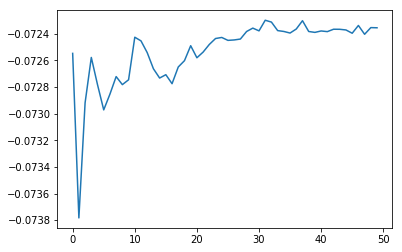

In [346]:
est_Theta = np.mean(Theta,axis=0)
plt.plot(theta_s*np.ones(50) - est_Theta)

The gradiant is very unstable, making the convergence very difficult

$\alpha_t$ is the learning rate monitoring the speed of convergence. If it is too small, the convergence will be too slow. If it is too big, the convergence becomes unstable.

$N$ is the number of episodes used to estimate the gradients. The bigger the better in terms of variance minimisation. But as the computation time is proportional to N, there is a time-performance trade-off to deal with.

### 1.5 Exploration in Policy Gradient

MBIE-BE and count based exploration

In [32]:
# exploration bonus
import bisect

class Bonus(object):
    def __init__(self, Beta=25):
        self.Beta= Beta
        self.bins = Bins()
        
    def fn(self,s,a):
        N = self.bins.update(s,a)
        b = self.Beta * math.sqrt(1/N)
        return b
    
class Bins:
    def __init__(self, pace_s=5, pace_a=5, bounds_s=[-40,40], bounds_a=[-40,40]):
        self.pace_s = pace_s
        self.pace_a = pace_a     
        self.t = 0
        self.bin_s = np.arange(bounds_s[0], bounds_s[1], pace_s)
        self.bin_a = np.arange(bounds_a[0], bounds_a[1], pace_a)
        self.counts = dict()
        
    def update(self, s, a):
        i = bisect.bisect(self.bin_s, s)
        j = bisect.bisect(self.bin_a, a)
        if (i, j) in self.counts.keys():
            self.counts[(i,j)] += 1
        else:
            self.counts[(i,j)] = 1
        self.t += 1
        return self.counts[(i,j)]

### Q2: REINFORCE with exploration bonus and test on the LQR domain

In [55]:
# We edit the simulation to add the exploration bonus

def simulation_bonus(env, policy, T):
    A,S,R = np.zeros(T),np.zeros(T),np.zeros(T)
    env.reset()
    S[0] = env.state
    bonus = Bonus()
    for t in range(T-1):
        A[t] = policy.action(env.state[0])
        next_state, R[t], boolean, array = env.step(A[t])
        R[t] += bonus.fn(S[t],A[t]) # <-------------------- bonus is added here
        S[t+1] = next_state[0]
    A[T-1] = policy.action(env.state)
    last_state, R[T-1], boolean, array = env.step(A[t]) 
    return S,A,R    
    
def REINFORCE_bonus(env, policy, update_rule, k_iterations, N, T, gamma):
    
    Theta = np.zeros(k_iterations)
    Theta[0] = policy.theta
    grad_J = np.zeros(N)
    
    for k in range(1,k_iterations):
        for n in range(N):
            S,A,R = simulation_bonus(env, policy, T)
            grad_J[n] = grad_discounted_reward(policy, S, A, R, gamma)
        grad_J_est = np.mean(grad_J)
        theta = Theta[k-1] + update_rule.fn(k-1,grad_J_est)
        Theta[k] = theta
        policy.new_theta(theta)
        
    return Theta

In [60]:
env = LQG1D('random')
policy = Gaussian(sigma=0.5)
update_rule = Standard_Update(alpha = lambda t:0.01/(t+1))
theta_s = -0.6

Theta = np.zeros((10,50))
for t in range(10):
    print('iteration:',t+1)
    Theta[t] = REINFORCE_bonus(env, policy, update_rule, k_iterations=50, N=50, T=100, gamma=0.9)  

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


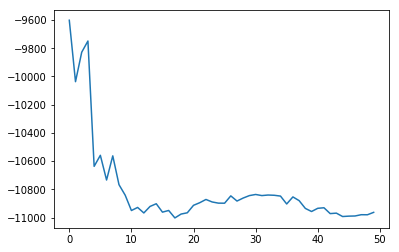

In [61]:
est_Theta = np.mean(Theta,axis=0)
plt.plot(theta_s*np.ones(50) - est_Theta)

Like before, the gradiant is very unstable making the convergence very difficult

## 2. Off-Policy Reinforcement Learning with Value Function Approximation

### 2.1 Experiments

In [1]:
# We approximate Q linearly

class LinearFQIPolicy(object):
    def __init__(self, dataset, action_space, gamma, Lambda):
        self.action_space = action_space
        self.gamma = gamma
        self.Lambda = Lambda
        self.theta = np.random.random((3,1))
        self.n_ep = len(dataset)
        self.T = dataset[0]['states'].shape[0]
        self.states = np.zeros(self.T * self.n_ep)
        self.actions = np.zeros(self.T * self.n_ep)
        self.rewards = np.zeros(self.T * self.n_ep)
        self.next_states = np.zeros(self.T * self.n_ep)
        self.Z = np.zeros((self.T * self.n_ep, 3))
        for i in range(self.n_ep):
            actions = dataset[i]['actions']
            states = dataset[i]['states']
            rewards = dataset[i]['rewards']
            next_states = dataset[i]['next_states']
            for t in range(self.T):
                a = actions[t]
                s = states[t]
                self.Z[i*self.T + t, :] = self.phi(s, a)
                self.states[i*self.T + t] = states[t]
                self.actions[i*self.T + t] = actions[t]
                self.rewards[i*self.T + t] = rewards[t]
                self.next_states[i*self.T + t] = next_states[t]                

    def Q(self, s, a):
        return  self.phi(s,a).T@self.theta 
         
    def phi(self, s,a):
        Phi = np.zeros(3)
        Phi[0] = a
        Phi[1] = s*a
        Phi[2] = s**2 + a**2
        return Phi
    
    def empirical_Bellman(self, X, R):
        Qa = [self.Q(X, a) for a in self.actions]
        return R + self.gamma * np.max(Qa)
    
    def update(self):
        y = np.zeros((self.T * self.n_ep, 1))
        for i in range(self.T * self.n_ep):
            y[i] = self.empirical_Bellman(self.states[i], self.rewards[i])
            
        self.theta = np.linalg.inv(self.Z.T.dot(self.Z) + self.Lambda * np.eye(3)).dot(self.Z.T).dot(y)
        
    def draw_action(self, s):
        rewards = []
        for a in self.action_space:
            rewards.append(self.Q(s, a))
        return self.action_space[np.argmax(rewards)]        

### Q3:  Fitted Q-Iteration algorithm with linear function approximation

In [77]:
env = LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50

actions = discrete_actions = np.linspace(-8, 8, 20)

Optimal K: [[-0.58840335]] Covariance S: 0.001


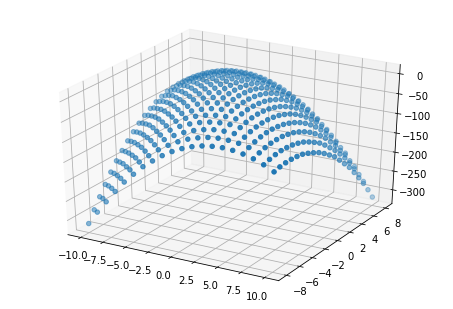

In [83]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])
Q_opt = Q_fun(SA)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(S, A, Q_opt)

plt.show()

In [105]:
# Initial behavioral policy

class BehaviouralPolicy(object):
    def __init__(self, actions):
        self.actions = actions
        
    def draw_action(self, s):
        return np.random.choice(self.actions)

In [178]:
def estimate_performance(env, policy, horizon, N, gamma):
    simulations = utils.collect_episodes(env, policy, horizon, N)
    J = 0
    for simulation in simulations:
        current_discount = 1
        r_sum = 0
        for r in simulation['rewards']:
            r_sum += current_discount * r
            current_discount = current_discount * gamma
        J += r_sum
    J = J / N 
    return J

In [181]:
actions = discrete_actions = np.linspace(-8, 8, 20)
beh_policy = BehaviouralPolicy(actions)
dataset = utils.collect_episodes(env, n_episodes=50, policy=beh_policy, horizon=50)
print('initialization')
fqi = LinearFQIPolicy(dataset=dataset, action_space=actions, gamma=0.9, Lambda=0.01)

Js = []
for t in range(10):
    print('iteration:',t+1)
    fqi.update()
    J = estimate_performance(env, fqi, horizon=50, N=50, gamma=0.9)
    Js.append(J)    

initialization
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


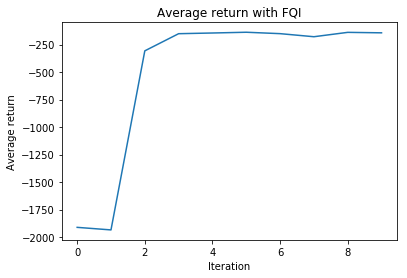

In [182]:
plt.figure()
plt.plot(range(10), Js)
plt.title("Average return with FQI")
plt.xlabel("Iteration")
plt.ylabel("Average return")
plt.show()

The algorithm seems to be less instable and to converge faster but it is computationally more expensive to do a iteration